# Introduction to solving Atari games with DQN

This notebook covers the basic implementation of agents interacting with Atari games through GYM toolkit. There are three agent implemented in this notebook: Random agent, Human Agent and DQN. 

## Table of contents
1. [Prerequisites](#Prerequisites)
	1. [Packages](#Packages)
	2. [Notebook configuration](#NotebookConfiguration)
2. [Atari Environments](#AtariEnvironments)
3. [Random Agent in Atari Environments](#RandomAgent)
3. [Human interaction in Atari Environments](#HumanInteraction)
4. [DQN in Atari Environments](#DQN)
	1. [Hyperparameters Configuration](#Hyperparameters)
	2. [Preprocessing](#Preprocessing)
	3. [Experience Replay Memory](#ExperienceReplay)
	4. [Epsilon Greedy action selection](#EpsilonGreedy)
	5. [Q and Q_Target Neural Networks](#QandQ_Target)
	6. [Network Fitting](#NetworkFitting)


# 1. Prerequisites <a name="Prerequisites"></a>

## 1.1 Packages<a name="Packages"></a>
Prior to running this code the following packages need to be installed. This can take some time:

In [1]:
%%capture
!pip install gym[atari];
!pip install tensorflow;
!pip install keras;
!conda install --yes --prefix {sys.prefix} opencv;

There might be a scenario where upon importing tensorflow the interpreter crashes. If this happens, try installing older version of tensorflow or seek help online. I have experienced issues with pip's Tensorflow v1.13.0 on AMD CPU, which were resolved by using v1.12.0 from conda (v1.12.0 not available on pip).

To use GPU accelerated version of tensorflow, uninstall tensorflow package and install package called <b>tensorflow-gpu</b>

## 1.2 Notebook configuration<a name="NotebookConfiguration"></a>
Rendering the frames might not be possible due to lack of display drivers. This is usually true when using clusters or services such as Google Colab. If there is no display driver installed, set ALLOW_RENDERING to False.

When running the code through standard Python interpreter rather than IPython, disable inline graph rendering.

In [2]:
ALLOW_RENDERING = True
ALLOW_INLINE = True

# 2. Atari Environments<a name="AtariEnvironments"></a>

There are multiple games in different configurations. Run the code below to  print all availible Atari games and their configurations <b>(The two lines are commented out due to a very long output)</b>: 

In [3]:
from gym import envs
envids = [spec.id for spec in envs.registry.all()]
print("There are ", len(envids), "configurations of different environments")

#UNCOMMENT THE LINES BELOW TO PRINT OUT THE ENVIRONMENT NAMES
#for envid in sorted(envids):
#    print(envid)

There are  797 configurations of different environments


Most Atari environments have 12 different configurations. Throughout this notebook <b>Pong</b> environment will be used. In case of environment configurations, Pong, like many other environments has the following configurations:

| Pixel | Ram | Explanation |
|:---|:---|:---:|
|Pong-v0|Pong-ram-v0| repeat_action_probability of 0.25 (meaning 25% of the time the previous action will be used instead of the new action |
|Pong-v4|Pong-ram-v4| probability of 0 to select non-issued action (always follow your issued action) |
|PongDeterministic-v0|Pong-ramDeterministic-v0| a fixed frameskip of 4, while for the env without Deterministic, frameskip is sampled from (2,5) |
|PongDeterministic-v4|Pong-ramDeterministic-v4| --- |
|PongNoFrameskip-v0|Pong-ramNoFrameskip-v0| no frame skip nor stochastic action repeat. |
|PongNoFrameskip-v4|Pong-ramNoFrameskip-v4| --- |

By default the observation returned are a 3D RGB pixel array, whereas RAM  observations return the state of the game from RAM. This notebook uses Pixel observations.

The first step when creating the environment is to create an environment for a specific game with <b>gym.make("Environment)Configuration_Name")</b>.
This returns an instance of the environment which will be used to interact with the game.

The environment is initialized with <b>env.reset()</b> which returns an initial observation, which is a 3D array of RGB pixel values.

We can render the current state of the environment with <b>env.render()</b>

In [4]:
import gym

env = gym.make("PongDeterministic-v4")
observation = env.reset()
ALLOW_RENDERING and env.render();

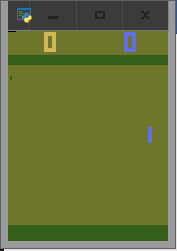
Running the code above should load a window like shown above.
Use <b>env.close()</b> to close the environment (exit button does not work).

In [5]:
env.close()

# Random Agent in Atari Environments<a name="RandomAgent"></a>

To interact with the environment lets simply take some action and observe the environment. We will implement the classic agent-environment loop shown below:
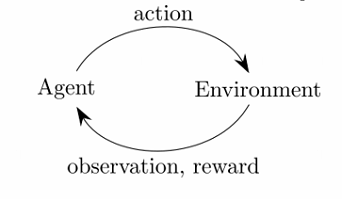

First, create a variable which will keep track of cumulative game score observed. Each observation returns a reward, usually +-1, 0 or 1. We sum the rewards received from all observations and store the final score in <b>game_score</b>. The goal of the game is to maximise this score before the terminal state.

Next we create a loop which will be used to allow the agent to continously interact with the environemnt at random. GYM function <b>env.action_space.sample()</b> selects a random action from environments action space, which varies in length depending on a game. <b>env.step(action)</b> executes the action and observes the environment. It returns 4 variables: <b>observation, reward, done, info</b>.

In the case of atari games, the four variables are of the following:

<b>observation</b> is a (210, 160, 3) shape which represents atari screen which is 210 x 160 pixels RGB

<b>reward</b> - reward for a specific action-observation

<b>done</b> - whether the state was terminal

<b>done</b> - whether the state was terminal


Finally, the reward for taking the action is cumulated, and the loop checks whether episode is terminal.


In [6]:
import gym
env = gym.make("PongDeterministic-v4")
observation = env.reset()

game_score = 0;

for steps in range(int(1e6)):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

    ALLOW_RENDERING and env.render()

    game_score += reward
        
    if(done):
        print("No of steps:", steps, "Game score:", game_score )
        break;      

No of steps: 910 Game score: -21.0


Running the code above should display the rendering of the atari game playing:
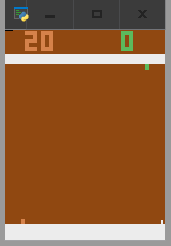
Close the environment.

In [7]:
env.close()

Note, even though we run the simulation 1 million times, it finishes much sooner depending on the game, e.g. after 1000 steps,  since this is how for many frames our agent can play before reaching the terminal state, which in case of atari games is usually running out of lives. The loop terminates when the agent reaches terminal state. <s>Often agent is capped to X number of frames to prevent degenerate startegies, e.g. Tennis, where agent can learn a strategy of not serving the ball in order to maximise its score, which would cause the game to never terminate.</s> <- This is true but done differently, put it somewhere else.

The rendering in this loop runs as fast as possible, usually it can achieve 500+ fps, making it impossible for a human eye to observe in detail whats happening. To slow down the rendering use sleep(0.033). If action selection would require more computation, e.g best action is approximated with a Neural Network, the rendering will slow down (GPU accelerated is around 200 FPS).

# Human interaction in Atari Environments<a name="HumanInteraction"></a>

Open AI Gym contains an utility which allows human players to play the game to better understand its mechanics.
Editing gym.make() argument with the name and configuration you wish to play, e.g Pong or MsPacman.
Usually the controlls are WASD and space.

In [8]:
def humanAgent():
    from gym.utils.play import play
    env = gym.make('MsPacmanNoFrameskip-v4')
    play(env, zoom=3, fps=60)
    
ALLOW_RENDERING and humanAgent();

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
(480, 630)


If ALLOW_RENDERING is set to True a new window should appear which will allow human player to play Atari games.
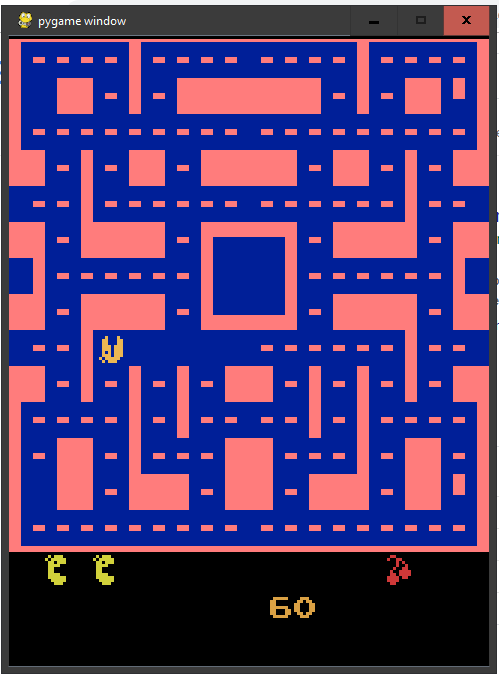

# DQN in Atari Environments<a name="DQN"></a>
The two previous implementations allowed agent to interact with the environment by taking a random action, or allowed human game controll. DQN uses Deep Neural Network to approximate Q-function, which returns the best action to take from the observed state.

## Hyperparameters Configuration<a name="Hyperparameters"></a>

Those are the original hyperparameters as they appeared in the original DQN paper

In [9]:
MINIBATCH_SIZE = 32
REPLAY_SIZE = 1000000
REPLAY_START_SIZE = 50000
AGENT_HISTORY_LENGTH = 4
TARGET_NETWORK_UPDATE_FREQ = 10000
GAMMA = 0.99
ACTION_REPEAT = 4
UPDATE_FREQ = 4
LEARNING_RATE = 0.00025
GRADIENT_MOMENTUM = 0.95
MIN_SQUARED_GRADIENT = 0.01
Epsilon_MAX = 1
Epsilon_MIN = 0.1
FINAL_EPLORATION_FRAME = 1000000
NO_OP_MAX = 30

## Utilities
Simple helper functions

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def showFrame(observation):
    plt.imshow(observation)
    plt.show()
    
def initEnvironment(envName='PongDeterministic-v4'):
    env = gym.make(envName)
    actionCount = env.action_space.n
    state = env.reset()    
    return env, state, actionCount;

## Preprocessing<a name="Preprocessing"></a>
This implementation of DQN learns from visual data. Raw atari data frames are 210 x 160 pixel images with 128 colours. To reduce memory and computation requirements the images are preprocessed.
Atari games contain a flickering where some objects appear only in even frames and some only in odd frames, which was due to limited number of Sprites Atari console could display at once.
To encode a single frame take the maximum value for each pixel value over the frame baing encoded and the previous frame. 
Next, the luminance value is extracted from RGB and rescaled to 84 x 84.
This preprocessing is applied to m most recent frames, 4 in case of the orginal paper. The frames are then stacked and fed into the Q-function.

NOTE: STEP BELOW DOES NOT EXTRACT MAXIMUM PIXEL VALUE FROM CURRENT AND PREVIOUS FRAME TO REMOVE FLICKERING (not implemented yet)

In [11]:
import cv2
import numpy as np
def preprocess(observation):
    res = cv2.resize(observation, (84, 84), interpolation=cv2.INTER_NEAREST )
    r, g, b = res[:,:,0], res[:,:,1], res[:,:,2]
    lum = 0.2126 * r + 0.7152 * g + 0.0722 * b# extract Relative_luminance
    return lum.astype('float32') / 128 - 1    # normalize, there is a bettwe way I think

Plot one original frame and one after preprocessing tp see how it is affected.

Before processing: (210, 160, 3)


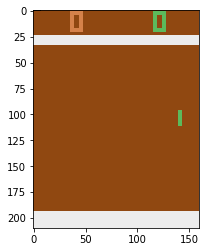

After processing: (84, 84)


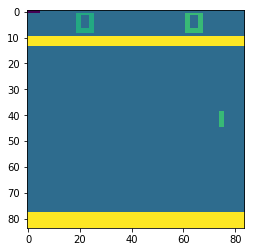

In [12]:
env, state, actionCount = initEnvironment()
observation, reward, done, info = env.step(0)

print("Before processing: " + str(np.array(observation).shape))
showFrame(observation)

newObservation = preprocess(observation)
print("After processing: " + str(np.array(newObservation).shape))
showFrame(newObservation)

Stack n last frames which will form the input to the NN. n = AGENT_HISTORY_LENGTH

In [13]:
def stack_frames(i, i2,memory):
    return memory[i] + memory[i2]

## Experience Replay Memory<a name="ExperienceReplay"></a>

At the start we wasnt to record N ammount of obserwations which will be randomly sampled for weights updates later on.
On 50k frames it takes the last method around 30s on the cluster.

In [14]:
#Step in the environment and observe the next state. 
#Record in memory and return s, a, r, s'
def step(action, state):
    observation, reward, done, info = env.step(action)
    nextState = preprocess(observation)
    
    memory.append([np.array(state, ndmin = 2), action, reward, np.array(nextState, ndmin=2)])
        
    #If done, we need to reset the environment so that it continues to run
    if done:
        #Append the terminal state
        #Check if the next state should be the terminal state (loop to itself)
        memory.append([ np.array(nextState, ndmin=2), action, reward,  np.array(None, ndmin=2)])
        state = env.reset()
        state = preprocess(state)
        #Increase i to account for additional state. DOESN'T WORK in PYTHON
    return state, action, reward, nextState, done

In [15]:
import collections
import time

memory = collections.deque(maxlen=REPLAY_SIZE)

env, state, actionCount = initEnvironment()
#the state after reset is the first state, eveything next is next state, which for next observation
#becomes the current state and so on
state = preprocess(state)

print("Initializing Memory of size", REPLAY_SIZE, "with", REPLAY_START_SIZE, "initial states. This could take some time.")
start = time.time()

# Since we have no controll over i when using for i in ... loop there is usually more
# I dont think impacts much, maybe in some games? E.g Pong tends to have ~50 samples more, MsPacman ~100
for i in range(REPLAY_START_SIZE):
    #Take a random action in initialization phase
    action = env.action_space.sample()    
    state, action, reward, nextState, done = step( action, state)
    state = nextState

end = time.time()

print("Finished adding", REPLAY_START_SIZE, "states in", (end - start), "seconds.\n")

Initializing Memory of size 1000000 with 50000 initial states. This could take some time.
Finished adding 50000 states in 50.92798352241516 seconds.



In [16]:
# If we simply add frames there is a bug? where the non-static environment 
# I wonder if this could have an use to remove the moving environment by summing x frames e.g. 
#multiFrame = memory[0][0]
#for i in range(1, 100):
#    multiFrame = multiFrame + memory[i][0]
#    showFrame(multiFrame)
# Would it be usefull to apply decay rate to older frames so that there is a trajectory of the dynamic environments with the oldest state being the most dim and the new state being the brightest?
#Fun thing to test once everything is running
#for i in range(1, 4):
#    showFrame(memory[i][0])

Sample MINIBATCH_SIZE from experience replay

There is something wrong in the way objects are stored in the buffer

When trying to selct appropriate columns I get (32, ) instead of (32, 84, 84)

In [17]:
#Return 
import random
def sampleRandom():
    return np.array(random.sample(memory, 32))
   

Print 5 frames to see how they look like:

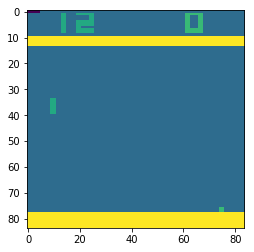

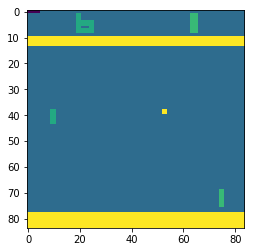

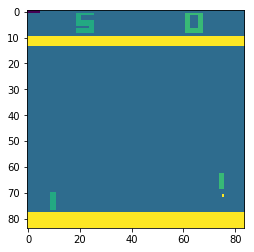

In [18]:
batch = sampleRandom()
for i, sample in enumerate(batch):
    if i >= 3:
        break
    showFrame(sample[0])

### Epsilon Greedy action selection<a name="EpsilonGreedy"></a>

In [19]:
#Check whether this is correct
def epsilon(i):
    if i >= FINAL_EPLORATION_FRAME:
        return Epsilon_MIN
    return Epsilon_MAX - ((Epsilon_MAX - Epsilon_MIN) / FINAL_EPLORATION_FRAME) * i

#Choose random action with epislon probability or the best action
def takeAction(state, i):
    if random.random() < epsilon(i):
        return random.randint(0, env.action_space.n - 1)
    else:
        #Max greedy action
        return np.argmax(Q.predict(state.reshape(1, 84, 84)))
        #Use NN to approx which action returns the highest return

## Q and Q_Target Neural Networks<a name="QandQ_Target"></a>
DQN's input is the state representation, in case of atari games 84 x 84 x 4 image, and the output is the Action space, with separate unit for each of the possible action, which in case of Atari games is between 4 and 18 actions.

The architecture is as follows:

Convolutional Neural Network is used
Its input is 4 stacked frames,  unrolled into a 84 x 84 x 4 image produced by the preprocessing step. The first hidden layer convolves 32 filters of 8 x 8 with stride 4 with the input image and applies a rectifier nonlinearity. The second hidden layer convolves 64 filters of 4 x 4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 3 x 3 with stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists of 512 rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action. The number of valid actions varied between 4 and 18.

Here we define the two neural networks which will be used 

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Convolution1D, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils

Q = Sequential([
    Convolution1D(32, (8), strides=(4), activation='relu'),
    Convolution1D(64, (4), strides=(2), activation='relu'),
    Convolution1D(64, (3), activation='relu'),
    Flatten(),
    Dense(units=512, activation='relu', input_shape=(512,1)),
    Dense(units=actionCount, activation='linear', input_shape=(512,1))
])

Q.compile(loss='mse', optimizer=RMSprop(lr=0.00025),
              metrics=['accuracy'])

batch = sampleRandom()
#batch values need to be converted to one hot vector
states = np.array([ o[0] for o in batch ])
rewards = np.array([ o[2] for o in batch ])

rewards = np_utils.to_categorical(rewards, num_classes=actionCount)

Q.fit(states, rewards, epochs=1, verbose=0)

Q_hat = Sequential([
    Convolution1D(32, (8), strides=(4), activation='relu'),
    Convolution1D(64, (4), strides=(2), activation='relu'),
    Convolution1D(64, (3), activation='relu'),
    Flatten(),
    Dense(units=512, activation='relu', input_shape=(512,1)),
    Dense(units=actionCount, activation='linear', input_shape=(512,1))
])

Q_hat.compile(loss='mse', optimizer=RMSprop(lr=0.00025),
              metrics=['accuracy'])

Q_hat.set_weights(Q.model.get_weights())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\Przemek\Anaconda3\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [21]:
def yFunction(state, reward):
    if(nextState is None):
        return reward
    else:
        return reward + GAMMA * np.amax(Q_hat.predict(state.reshape(1, 84, 84)))

In [22]:
#batch values need to be converted to one hot vector

#batchRewards = np_utils.to_categorical(batchRewards, num_classes=actionCount)

#Q.fit(batchStates, batchRewards, epochs=1, verbose=0)

# Network Fitting<a name="NetworkFitting"></a>

In [23]:
while True:
    env, state, actionCount = initEnvironment()
    state = preprocess(state)
    cumulative_reward = 0
    stepsSinceUpdate = 0
    episode = 0
    
    while True:            
    # self.env.render()
        action = takeAction(state, i)
        episode += 1
        stepsSinceUpdate += 1
        state, action, reward, nextState, done = step(action, state)
        
        batch = sampleRandom()
                
        x = np.zeros((32, 84, 84))
        y = np.zeros((32, actionCount))
        errors = np.zeros(32)
        

        states = np.array([ o[0] for o in batch ])
        states_ = np.array([ (np.zeros((84, 84)) if o[3].shape[0] is not 84 else o[3]) for o in batch ])
        
        p = Q.predict(states)
        p_ = Q_hat.predict(states_)  
            
        for i in range(32):
            s = batch[i][0]; a = int(batch[i][1]); r = batch[i][2]; s_ = batch[i][3]
            
            t = p[i]
            oldVal = t[a]
            #print(r)
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * np.argmax(p_[i])

            x[i] = s
            y[i] = t
            #print(y)
            errors[i] = abs(oldVal - t[a])
            
        Q.fit(x, y, epochs=1, batch_size = 32, verbose=0)
      
        state = nextState
        cumulative_reward += reward       
        
        if stepsSinceUpdate > TARGET_NETWORK_UPDATE_FREQ == 0:
            Q_hat.set_weights(Q.model.get_weights())
            stepsSinceUpdate = 0
        
        if done:
            print("Finished game with reward:", cumulative_reward)
            break
    break

Finished game with reward: -20.0


### Main Loop
TESTING


env, state, actionCount = initEnvironment()
state = preprocess(state)
cumulative_reward = 0

for episode in range(10000):
    #print(state.shape)
    state, action, reward, nextState, done = step(action, state)
    
    cumulative_reward = cumulative_reward + reward
    
    action = takeAction(state, episode)    
    #print("Action", action)

        
    if(done):
        print("Finished game with reward:", cumulative_reward)
        cumulative_reward = 0

    #If the network converged escape
    if(episode > 1200000):
        print("Finished at episode:", episode)
        break
            
    #sample from memory
    #print("mem shape", memory[310][0].shape)

    #for i in range(MINIBATCH_SIZE):
    #    s = np.array([batchStates[i]])
        #print("batch size", s.shape)
        #print(yFunction(s, batchStates[i][2]))
    Q.predict(batchStates)
    batchValues = np_utils.to_categorical(batchValues, num_classes=actionCount)
    Q.fit(batchStates, batchValues, epochs=1, verbose=0)
